In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-14 01:52:09.768497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-14 01:52:09.768526: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
df = pd.read_csv('colheitas_cst.csv', parse_dates=['date'])
df = df.set_index('date')
df = df.groupby('cst').resample('M').sum()

In [4]:
df

nr
cst     date            
Coimbra 1999-01-31  2011
        1999-02-28  2305
        1999-03-31  2368
        1999-04-30  1779
        1999-05-31  3978
...                  ...
Porto   2019-08-31  6296
        2019-09-30  7241
        2019-10-31  7871
        2019-11-30  7162
        2019-12-31  6936

[756 rows x 1 columns]

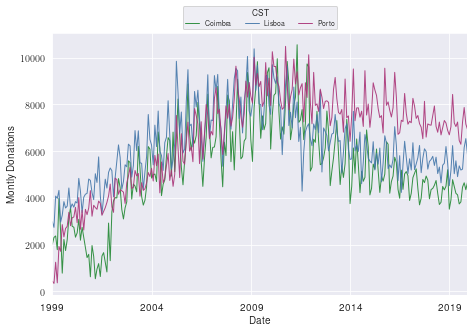

In [5]:
df.pivot_table(values="nr",index="date",columns="cst").plot(figsize=(17*cm,12*cm), linewidth=1, alpha=0.9, color=[colors[2], colors[0], colors[5]], xlabel='Date', ylabel='Montly Donations')
plt.legend(['Coimbra', 'Lisboa', 'Porto'], title_fontsize='small', fontsize='x-small', title='CST', loc="lower center", bbox_to_anchor=(0.5,1), ncol=5)
plt.tight_layout()
plt.savefig('figures/supply_montly_cst.pdf', bbox_inches = "tight")

### Create batches of training data (12 months)

In [6]:
def split_sequence(sequence, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [7]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(LSTM(units=70, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=500, callbacks=[callback])
    return model 

In [8]:
def train_predict(dataset, test, actual):
    n_steps_in, n_steps_out, slide = 6, 2, 1
    X, y = split_sequence(dataset, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    #print(X[0], y[0], len(X[0]), len(y[0]))
    model = fit(X, y, n_input, n_output)      
    
    mae, rmse, smape = list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input).reshape(-1, 1)
        pred = scaler.inverse_transform(pred)
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
        #print(x_input, current_pred)
    
    return mae, rmse, smape

In [9]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [10]:
def measure_error(actual, pred, step_in, step_out, index):
    #print(actual[index+step_in:index+step_in+step_out],pred,index+step_in,index+step_in+step_out)
    mae = mean_absolute_error(actual[index+step_in:index+step_in+step_out], pred)
    rmse = np.sqrt(mean_squared_error(actual[index+step_in:index+step_in+step_out], pred))
    smape = sMAPE(actual[index+step_in:index+step_in+step_out], pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [11]:
df = df.pivot_table('nr', 'date', 'cst')

In [12]:
dataset = df[['Coimbra']].values
dataset = df[['Coimbra']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
mae1, rmse1, smape1 = train_predict(dataset[:216], dataset[216:], df[['Coimbra']][216:].values)

2022-10-14 01:52:12.630500: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-14 01:52:12.630542: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-14 01:52:12.631108: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
7/7 [==============================] - 2s 6ms/step - loss: 0.2868
Epoch 2/500
7/7 [==============================] - 0s 7ms/step - loss: 0.2296
Epoch 3/500
7/7 [==============================] - 0s 6ms/step - loss: 0.1719
Epoch 4/500
7/7 [==============================] - 0s 7ms/step - loss: 0.1096
Epoch 5/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0489
Epoch 6/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0224
Epoch 7/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0216
Epoch 8/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0165
Epoch 9/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0161
Epoch 10/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0147
Epoch 11/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0138
Epoch 12/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0133
Epoch 13/500
7/7 [==============================] - 0s 5ms/st

7/7 [==============================] - 0s 6ms/step - loss: 0.0082
Epoch 105/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0081
Epoch 106/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0081
Epoch 107/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0081
Epoch 108/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0080
Epoch 109/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0081
Epoch 110/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0079
Epoch 111/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0080
Epoch 112/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0080
Epoch 113/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0081
Epoch 114/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0079
Epoch 115/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0080
Epoch 116/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 7ms/step - loss: 0.0066
Epoch 207/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0067
Epoch 208/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0069
Epoch 209/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0068
Epoch 210/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0069
Epoch 211/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0073
Epoch 212/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0074
Epoch 213/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0075
Epoch 214/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0075
Epoch 215/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0069
Epoch 216/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0073
Epoch 217/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 218/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 309/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0064
Epoch 310/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0065
Epoch 311/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0065
Epoch 312/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0064
Epoch 313/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 314/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 315/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 316/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0065
Epoch 317/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0067
Epoch 318/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 319/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 320/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 411/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 412/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 413/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 414/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 415/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 416/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 417/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 418/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 419/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 420/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 421/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 422/500
7/7 [==============================] - 0

In [13]:
dataset = df[['Lisboa']].values
dataset = df[['Lisboa']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
mae2, rmse2, smape2 = train_predict(dataset[:216], dataset[216:], df[['Lisboa']][216:].values)

Epoch 1/500
7/7 [==============================] - 1s 4ms/step - loss: 0.2660
Epoch 2/500
7/7 [==============================] - 0s 5ms/step - loss: 0.2019
Epoch 3/500
7/7 [==============================] - 0s 4ms/step - loss: 0.1442
Epoch 4/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0879
Epoch 5/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 6/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0198
Epoch 7/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0247
Epoch 8/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0186
Epoch 9/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0187
Epoch 10/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0176
Epoch 11/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 12/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0170
Epoch 13/500
7/7 [==============================] - 0s 5ms/st

7/7 [==============================] - 0s 5ms/step - loss: 0.0145
Epoch 105/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0145
Epoch 106/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0147
Epoch 107/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 108/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0146
Epoch 109/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0147
Epoch 110/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0145
Epoch 111/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 112/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0145
Epoch 113/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 114/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0143
Epoch 115/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0143
Epoch 116/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 5ms/step - loss: 0.0133
Epoch 207/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0133
Epoch 208/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0131
Epoch 209/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0131
Epoch 210/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 211/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0131
Epoch 212/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0129
Epoch 213/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0134
Epoch 214/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0134
Epoch 215/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 216/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0137
Epoch 217/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0132
Epoch 218/500
7/7 [==============================] - 

7/7 [==============================] - 0s 8ms/step - loss: 0.0123
Epoch 309/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0124
Epoch 310/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0124
Epoch 311/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0122
Epoch 312/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0121
Epoch 313/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0121
Epoch 314/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 315/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 316/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0119
Epoch 317/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0124
Epoch 318/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 319/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0140
Epoch 320/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 6ms/step - loss: 0.0116
Epoch 411/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0120
Epoch 412/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0115
Epoch 413/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0121
Epoch 414/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 415/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 416/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0119
Epoch 417/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 418/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 419/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 420/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 421/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 422/500
7/7 [==============================] - 0

In [14]:
dataset = df[['Porto']].values
dataset = df[['Porto']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
mae3, rmse3, smape3 = train_predict(dataset[:216], dataset[216:], df[['Porto']][216:].values)

Epoch 1/500
7/7 [==============================] - 1s 6ms/step - loss: 0.3438
Epoch 2/500
7/7 [==============================] - 0s 6ms/step - loss: 0.2697
Epoch 3/500
7/7 [==============================] - 0s 6ms/step - loss: 0.1947
Epoch 4/500
7/7 [==============================] - 0s 6ms/step - loss: 0.1120
Epoch 5/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0383
Epoch 6/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0144
Epoch 7/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0165
Epoch 8/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0079
Epoch 9/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0098
Epoch 10/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0079
Epoch 11/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0071
Epoch 12/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 13/500
7/7 [==============================] - 0s 5ms/st

7/7 [==============================] - 0s 8ms/step - loss: 0.0054
Epoch 105/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 106/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0053
Epoch 107/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 108/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 109/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 110/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0054
Epoch 111/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 112/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 113/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 114/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 115/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 116/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 207/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 208/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0054
Epoch 209/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 210/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 211/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 212/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 213/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 214/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0052
Epoch 215/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 216/500
7/7 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 217/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 218/500
7/7 [==============================] - 0

In [15]:
mae = np.average([mae1, mae2, mae3], axis=0)
rmse = np.average([rmse1, rmse2, rmse3], axis=0)
smape = np.average([smape1, smape2, smape3], axis=0)

### Calculate Error

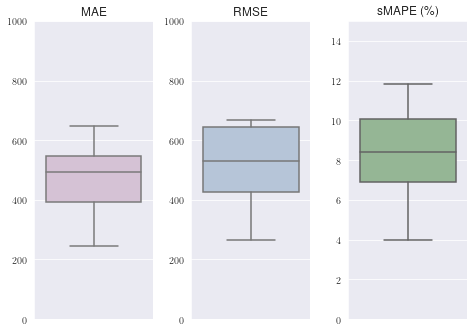

In [19]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 1000))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 1000))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 15))
plt.tight_layout()
plt.savefig('figures/supply_lstm_monthly_cst_single_boxplot.pdf')

In [20]:
supply_lstm_month_cst_single = [mae,rmse,smape]
%store supply_lstm_month_cst_single

Stored 'supply_lstm_month_cst_single' (list)
